In [104]:
%pip install fuzzywuzzy

Note: you may need to restart the kernel to use updated packages.


In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from scipy.stats import describe
import re

In [106]:
# df = pd.read_csv('../data/precios_cervezas_2025.csv')

# df_productos = pd.read_csv("../data/ids_cervezas_enriquecidos.csv")

# # Merge con productos (left join para conservar todos los precios)
# df_merged = df.merge(df_productos, on='id_producto', how='left')

# # Identificá las columnas fijas y las de fechas (pueden ser detectadas automáticamente si querés)
# id_cols = ['id_comercio', 'id_bandera', 'id_sucursal', 'nombre_comercio', 'provincia'] + df_productos.columns.tolist()
# date_cols = [col for col in df.columns if col not in id_cols]

# # Asegurar que los nombres de las columnas de fecha estén en string
# df_merged.columns = df_merged.columns.astype(str)

# # Melt para despivotear
# df_long = df_merged.melt(id_vars=id_cols, value_vars=date_cols,
#                   var_name='fecha', value_name='precio')

# df_long = df_long.drop(['specs_parsed', 'specs_dict'], axis=1)

# # Convertir fechas de '20250101' a datetime
# df_long['fecha'] = pd.to_datetime(df_long['fecha'], format='%Y%m%d')

# # Ordenar por producto, comercio y fecha
# df_long = df_long.sort_values(by=['id_producto', 'id_comercio', 'fecha'])

# df_long = df_long.reset_index(drop=True)

# df_long.to_csv("../data/precios_cervezas_2025_transformado.csv", index=False)

In [107]:
df = pd.read_csv('../data/precios_cervezas_2025_transformado.csv')

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_10267/1648959241.py:1: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/precios_cervezas_2025_transformado.csv')


## Caso de Negocio
### Problema de Negocio
### Objetivo
### Datos Disponibles

La información obtenida recopila registros diarios de precios de distintos productos bajo la categoria **cervezas**.

### Variable Target
### Población Objetivo

Se redujo el alcance del trabajo a la categoria de cervezas. Además, no se tienen en cuenta mayoristas, unicamente se analizaran precios de supermercados.

### Periodos Considerados en el Dataset

El dataset tiene información diaria de precios de cada comercio, sucursal y producto. Se tiene información de todo 2025.

### Estrategias y Soluciones Propuestas

## Análisis y Limpieza de Datos

In [108]:
df.head()

,id_comercio,id_bandera,id_sucursal,nombre_comercio,provincia,id_producto,productos_descripcion,name,description,brand,...,Width,Binding,Part Number,Manufacturer,Height,Number Of Items,volume_raw,volume_ml,fecha,precio
0,12,1,44,COTO CICSA,AR-C,3162330450010,CERVEZA LAGER STARBERG LAT 500 ML,Cerveza Starberg Lager 500 Ml,No description found.,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,500 ml,500.0,2025-01-01,2300.0
1,12,1,45,COTO CICSA,AR-C,3162330450010,CERVEZA LAGER STARBERG LAT 500 ML,Cerveza Starberg Lager 500 Ml,No description found.,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,500 ml,500.0,2025-01-01,2300.0
2,12,1,51,COTO CICSA,AR-B,3162330450010,CERVEZA LAGER STARBERG LAT 500 ML,Cerveza Starberg Lager 500 Ml,No description found.,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,500 ml,500.0,2025-01-01,2300.0
3,12,1,56,COTO CICSA,AR-C,3162330450010,CERVEZA LAGER STARBERG LAT 500 ML,Cerveza Starberg Lager 500 Ml,No description found.,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,500 ml,500.0,2025-01-01,2300.0
4,12,1,60,COTO CICSA,AR-C,3162330450010,CERVEZA LAGER STARBERG LAT 500 ML,Cerveza Starberg Lager 500 Ml,No description found.,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,500 ml,500.0,2025-01-01,2300.0


In [109]:
df.shape

(22054920, 36)

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22054920 entries, 0 to 22054919
Data columns (total 36 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id_comercio            int64  
 1   id_bandera             int64  
 2   id_sucursal            int64  
 3   nombre_comercio        object 
 4   provincia              object 
 5   id_producto            int64  
 6   productos_descripcion  object 
 7   name                   object 
 8   description            object 
 9   brand                  object 
 10  specs                  object 
 11  category               object 
 12  ingredients            object 
 13  Size                   object 
 14  Country of Origin      object 
 15  Countries              object 
 16  Stores                 object 
 17  Alcohol %              object 
 18  Weight                 object 
 19  Color                  object 
 20  Unit Size & Type       object 
 21  Vintage                object 
 22  Style           

### Detalle de cada columna

Comercios:
- **id_comercio:** es el codigo identificatorio del comercio.
- **nombre_comercio:** es el nombre del comercio.

Sucursales:
- **id_sucursal:** codigo identificiatorio del local del respectivo comercio. 
- **provincia:** provincia argentina donde esta ubicado el comercio. 

Productos:
- i**id_producto:** codigo identificatorio del producto. Codigo EAN (codigo de barras)
- **productos_descripcion:** detalle del producto.
- *name:* nombre del producto.
- *description:* descripción del producto.
- *brand:* marca del producto.
- *specs:* lista de atributos del producto.
- *category:* categoria del producto.
- *ingredients:* lista de ingredientes del producto.
- *Size:* tamaño del producto. 
- *Contry of Origin:* país de origen del producto.
- *Stores:* tienda donde se encuentra ese codigo de EAN del producto.
- *Alcohol %:* porcentaje de alcohol del producto.
- *Weight*: peso del producto.
- *Color:* color del producto.
- *Unit Size & Type:* tamaño y tipo de la unidad del producto.
- *Vintage:* descripción de producto usado o nuevo.
- *Style:* detalle del tipo de producto.
- *Length:* largo del producto.
- *Product Group:* agrupación de categoria del producto.
- *Model Number:* codigo de identificación del modelo del producto.
- *Width:* ancho del producto.
- *Binding:* sector del producto.
- *Part Number:* numero de parte del producto.
- *Manufacturer:* nombre del fabricante del producto.
- *Height:* alto del producto.
- *Number Of Items:* cantidad de items del producto.
- *volume_raw:* volumen del producto.
- *volume_ml:* volumen en mililitros del producto.

Precio:
- **precio:** valor del producto en pesos.
- **fecha:** dia en el que se tomo el registro. 

Las columnas identificadas con itálica son columnas extraidas con una API externa para aportarle información de valor a la base. Estas refieren al codigo EAN universal del producto y obtienen información detalla de este. 

#### Comercios

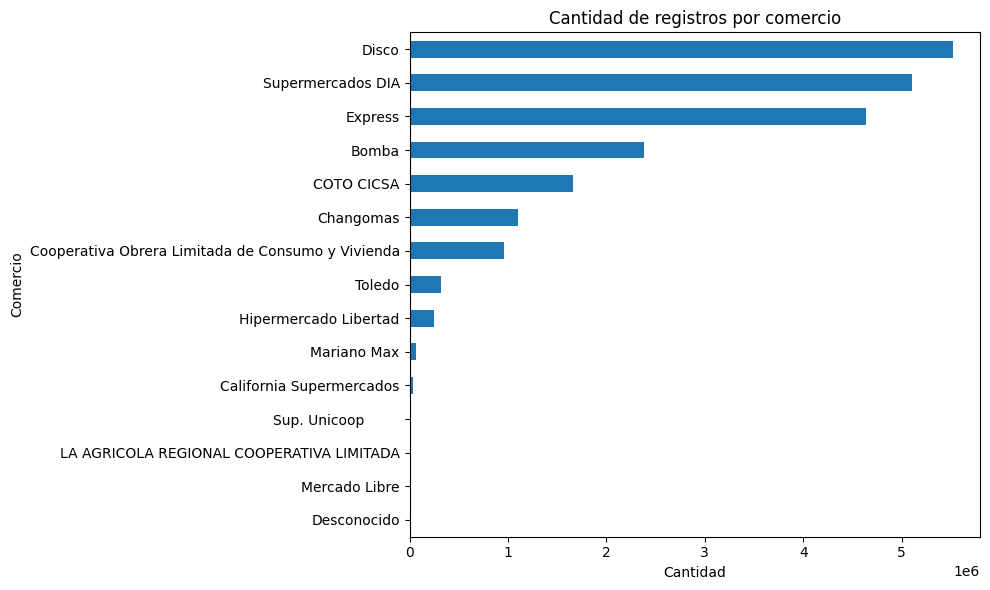

In [111]:
comercios_counts = df['nombre_comercio'].value_counts()
comercios_counts = comercios_counts.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
comercios_counts.plot(kind='barh')
plt.title('Cantidad de registros por comercio')
plt.xlabel('Cantidad')
plt.ylabel('Comercio')
plt.tight_layout()
plt.grid(False)
plt.show()

#### Sucursales

In [112]:
df[['nombre_comercio', 'id_sucursal']].drop_duplicates()['nombre_comercio'].value_counts()

nombre_comercio
Supermercados DIA                                    1038
Express                                               567
Disco                                                 270
Bomba                                                 170
Cooperativa Obrera Limitada de Consumo y Vivienda     149
COTO CICSA                                            121
Changomas                                              91
Toledo                                                 28
Hipermercado Libertad                                  15
Mariano Max                                            11
California Supermercados                                7
LA AGRICOLA REGIONAL COOPERATIVA LIMITADA               4
Sup. Unicoop                                            3
Mercado Libre                                           1
Desconocido                                             1
Name: count, dtype: int64

Algunos comercios tienen muchas sucursales, pero no necesariamente los precios cambian entre ellas. ¿Hay más de un precio distinto para la misma combinación de producto, comercio, fecha?

In [113]:
# Función auxiliar para calcular moda
def calcular_moda(x):
    moda = st.mode(x, keepdims=True).mode
    return moda[0] if len(moda) > 0 else None

# Ver cuántos precios distintos hay por producto, comercio y fecha
variacion = df.groupby(['id_producto', 'id_comercio', 'fecha']).agg(
    precios_distintos=('precio', lambda x: x.nunique()),
    media_precio=('precio', 'mean'),
    moda_precio=('precio', calcular_moda),
    std_precio=('precio', 'std')
)

In [114]:
# Filtrar los casos con más de un precio diferente
duplicados = variacion[variacion['precios_distintos'] > 1]

# Mostrar algunos casos
duplicados.head()

precios_distintos  media_precio  \
id_producto   id_comercio fecha                                         
3162330450010 12          2025-01-01                  3   2305.217073   
                          2025-01-02                  3   2305.217073   
                          2025-01-03                  3   2305.217073   
                          2025-01-04                  3   2305.217073   
                          2025-01-05                  3   2305.217073   

                                      moda_precio  std_precio  
id_producto   id_comercio fecha                                
3162330450010 12          2025-01-01       2300.0   24.335611  
                          2025-01-02       2300.0   24.335611  
                          2025-01-03       2300.0   24.335611  
                          2025-01-04       2300.0   24.335611  
                          2025-01-05       2300.0   24.335611

In [115]:
# Ejemplo: Tomo el id de comercio y producto con mas duplicados
ejemplo = duplicados.index[0]
df[(df['id_producto'] == ejemplo[0]) & (df['id_comercio'] == ejemplo[1]) & (df['fecha'] == ejemplo[2])].groupby(['id_producto', 'id_comercio', 'fecha'])['precio'].value_counts()

id_producto    id_comercio  fecha       precio
3162330450010  12           2025-01-01  2300.0    39
                                        2375.9     1
                                        2438.0     1
Name: count, dtype: int64

Se filtran duplicados de producto, comercio y fecha tomando la moda del precio. Asi nos desasemos de registros que hacen referencia a sucursales distintas de un mismo comercio. 

In [116]:
# Agrupar por claves únicas
df = (
    df.groupby(['id_producto', 'id_comercio', 'fecha'], as_index=False)
      .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
    )

#### Productos

¿Cuantos productos tienen descripción?

In [117]:
df['TieneDescripcion'] = df['name'].notna().astype(int)

In [118]:
productos_unicos = df[['id_producto', 'TieneDescripcion']].drop_duplicates()
productos_unicos['TieneDescripcion'].value_counts()

TieneDescripcion
1    389
0     55
Name: count, dtype: int64

In [119]:
df['TieneDescripcion'].value_counts()

TieneDescripcion
1    174840
0     10080
Name: count, dtype: int64

In [120]:
# Nos quedamos unicamente con los productos que tienen descripción
data = df[df['TieneDescripcion'] == 1]

¿Cuál es nuestra cartera de productos?

In [121]:
print('Hay {} productos únicos'.format(data['productos_descripcion'].nunique()))

Hay 350 productos únicos


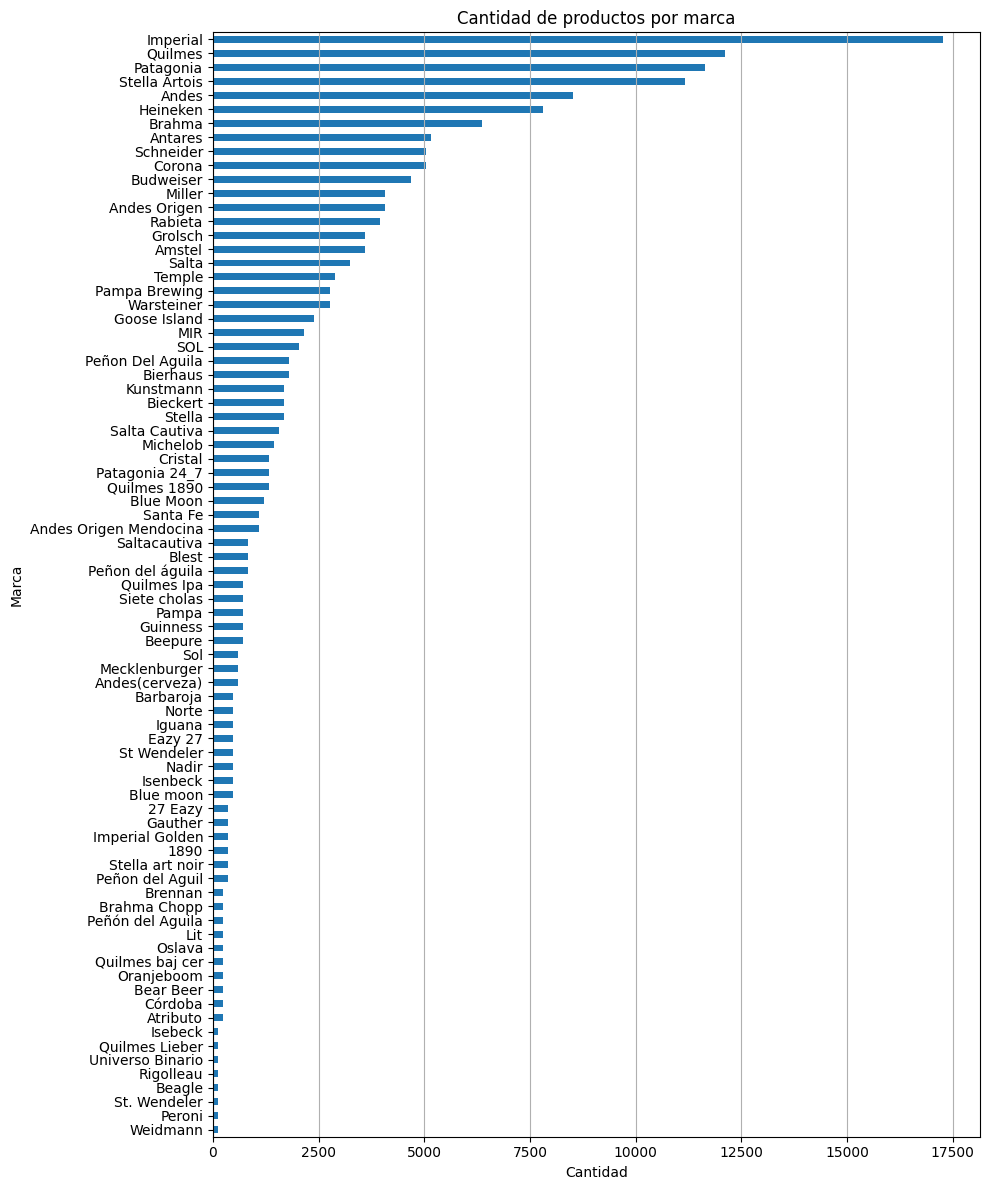

In [122]:
# Suponiendo que ya tenés tu DataFrame cargado como df
brand_counts = data['brand'].value_counts()

# Orden descendente para gráfico horizontal (de mayor a menor arriba)
brand_counts = brand_counts.sort_values(ascending=True)

# Crear gráfico
plt.figure(figsize=(10, 12))
brand_counts.plot(kind='barh')
plt.title('Cantidad de productos por marca')
plt.xlabel('Cantidad')
plt.ylabel('Marca')
plt.tight_layout()
plt.grid(axis='x')
plt.show()

In [123]:
data['brand_clean'] = data['brand'].astype(str).str.upper().str.strip()

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_10267/3728496856.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['brand_clean'] = data['brand'].astype(str).str.upper().str.strip()


In [124]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Lista de marcas únicas
marcas_unicas = data['brand_clean'].dropna().unique()

# Elegir una base (por ejemplo, las top 20 marcas)
top_marcas = data['brand_clean'].value_counts().head(40).index.tolist()

# Mapear marcas similares a las top
fuzzy_map = {}
for marca in marcas_unicas:
    mejor_match, score = process.extractOne(marca, top_marcas)
    if score >= 90:  # umbral ajustable
        fuzzy_map[marca] = mejor_match
    else:
        fuzzy_map[marca] = marca  # sin cambio

# Aplicar el mapeo
data['brand_normalizada'] = data['brand_clean'].map(fuzzy_map)

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_10267/3114616872.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['brand_normalizada'] = data['brand_clean'].map(fuzzy_map)


In [125]:
data['brand_normalizada'].value_counts().sort_index().head(50)

brand_normalizada
27 EAZY                     360
AMSTEL                     3600
ANDES                      9120
ANDES ORIGEN               4080
ANDES ORIGEN MENDOCINA     1080
ANTARES                    5160
ATRIBUTO                    240
BARBAROJA                   480
BEAGLE                      120
BEAR BEER                   240
BEEPURE                     720
BIECKERT                   1680
BIERHAUS                   1800
BLEST                       840
BLUE MOON                  1680
BRAHMA                     6600
BUDWEISER                  4680
CORONA                     5040
CRISTAL                    1320
CÓRDOBA                     240
EAZY 27                     480
GAUTHER                     360
GOOSE ISLAND               2400
GROLSCH                    3600
GUINNESS                    720
HEINEKEN                   7800
IGUANA                      480
IMPERIAL                  17640
ISEBECK                     120
ISENBECK                    480
KUNSTMANN             

In [151]:
reemplazos_similares = {
    # Marcas duplicadas o mal normalizadas
    'STELLA': 'STELLA ARTOIS',

    'PATAGONIA 24_7': 'PATAGONIA',

    'QUILMES 1890': 'QUILMES',

    'HEINEKEN CERVEZA LATA': 'HEINEKEN',

    'SALTACAUTIVA': 'SALTA CAUTIVA',

    'EAZY 27': '27 EAZY',

    'ISEBECK': 'ISENBECK',
}

data['brand_normalizada'] = data['brand_normalizada'].replace(reemplazos_similares)

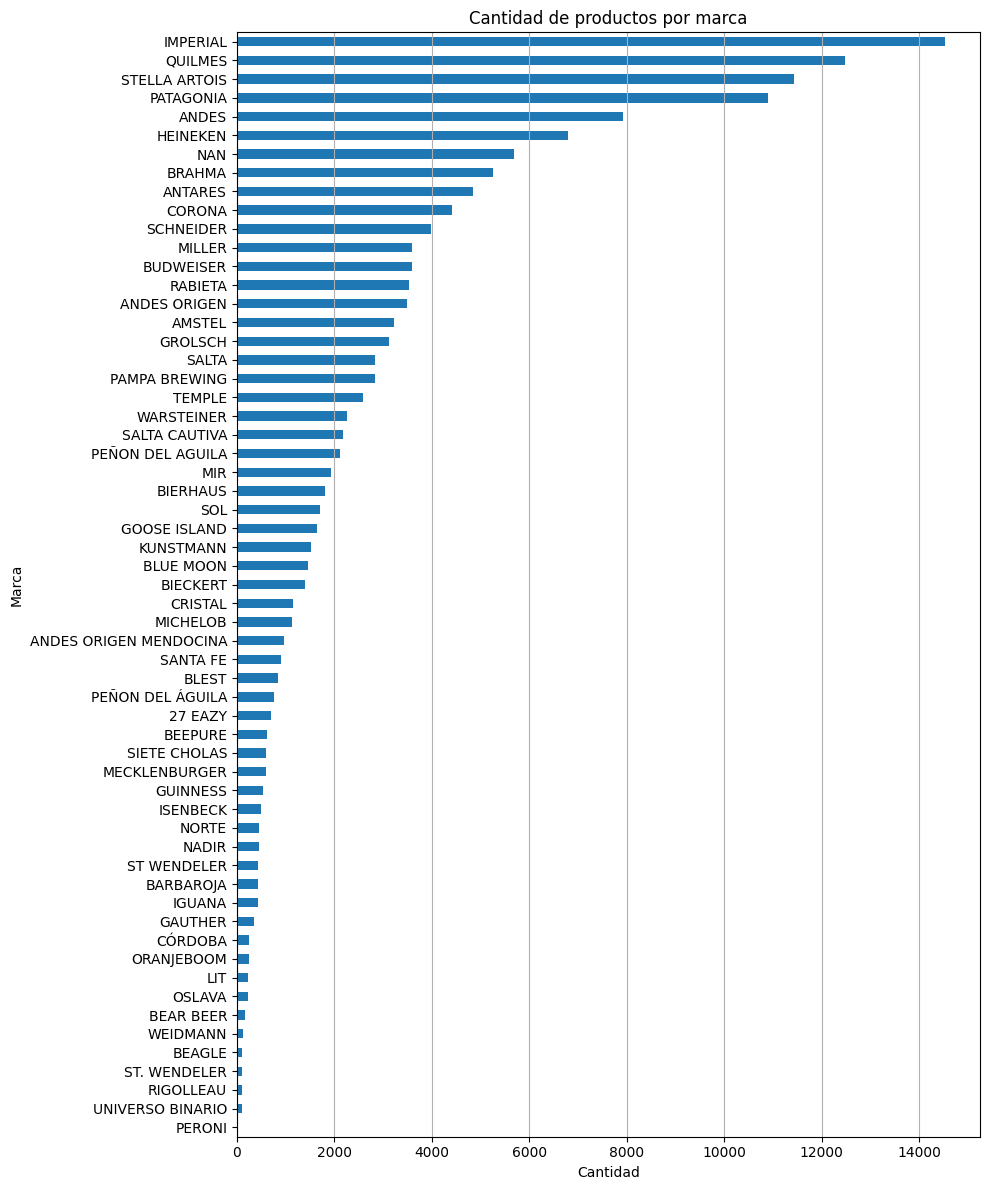

In [152]:
# Suponiendo que ya tenés tu DataFrame cargado como df
brand_counts = data['brand_normalizada'].value_counts()

# Orden descendente para gráfico horizontal (de mayor a menor arriba)
brand_counts = brand_counts.sort_values(ascending=True)

# Crear gráfico
plt.figure(figsize=(10, 12))
brand_counts.plot(kind='barh')
plt.title('Cantidad de productos por marca')
plt.xlabel('Cantidad')
plt.ylabel('Marca')
plt.tight_layout()
plt.grid(axis='x')
plt.show()

In [128]:
reemplazos_similares = {
    # Calibres duplicadas o mal normalizadas
    473000: 473,
    4733: 473,
    470: 473
}

data['volume_ml'] = data['volume_ml'].replace(reemplazos_similares)

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_10267/3348461076.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['volume_ml'] = data['volume_ml'].replace(reemplazos_similares)


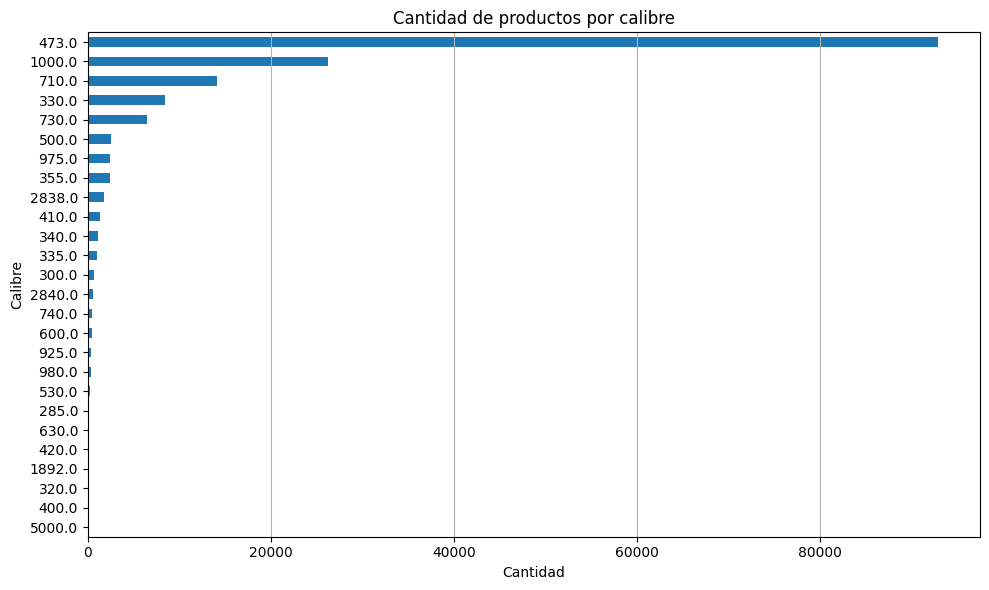

In [129]:
# Suponiendo que ya tenés tu DataFrame cargado como df
brand_counts = data['volume_ml'].value_counts()

# Orden descendente para gráfico horizontal (de mayor a menor arriba)
brand_counts = brand_counts.sort_values(ascending=True)

# Crear gráfico
plt.figure(figsize=(10, 6))
brand_counts.plot(kind='barh')
plt.title('Cantidad de productos por calibre')
plt.xlabel('Cantidad')
plt.ylabel('Calibre')
plt.tight_layout()
plt.grid(axis='x')
plt.show()

Para acotar la cantidad de calibres presentados se redondea a la centena inferior más cercana. 

In [130]:
data['volume_ml_redondeado'] = (data['volume_ml'] // 100) * 100

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_10267/3038545324.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['volume_ml_redondeado'] = (data['volume_ml'] // 100) * 100


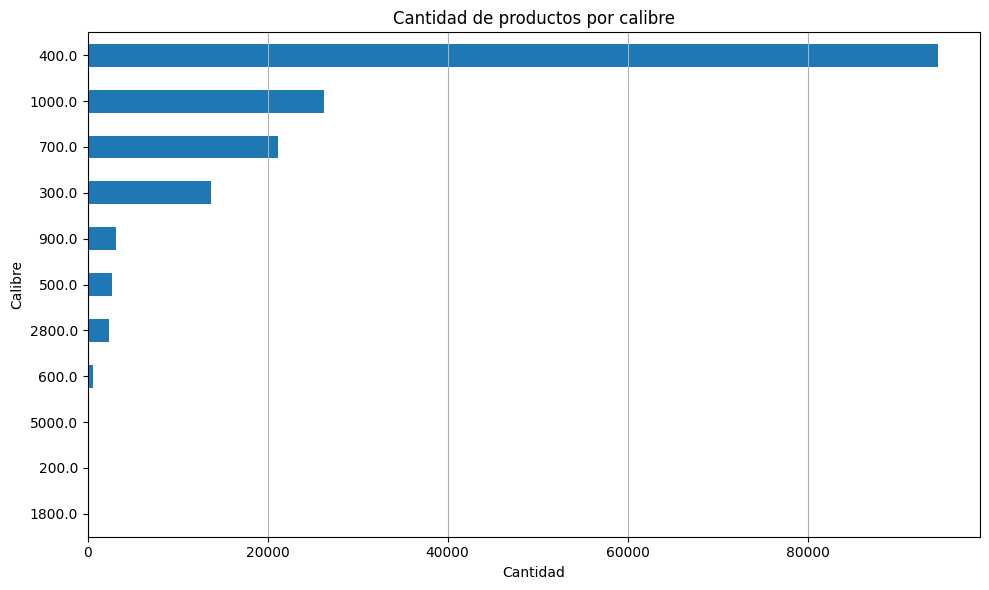

In [131]:
# Suponiendo que ya tenés tu DataFrame cargado como df
brand_counts = data['volume_ml_redondeado'].value_counts()

# Orden descendente para gráfico horizontal (de mayor a menor arriba)
brand_counts = brand_counts.sort_values(ascending=True)

# Crear gráfico
plt.figure(figsize=(10, 6))
brand_counts.plot(kind='barh')
plt.title('Cantidad de productos por calibre')
plt.xlabel('Cantidad')
plt.ylabel('Calibre')
plt.tight_layout()
plt.grid(axis='x')
plt.show()

#### Precio

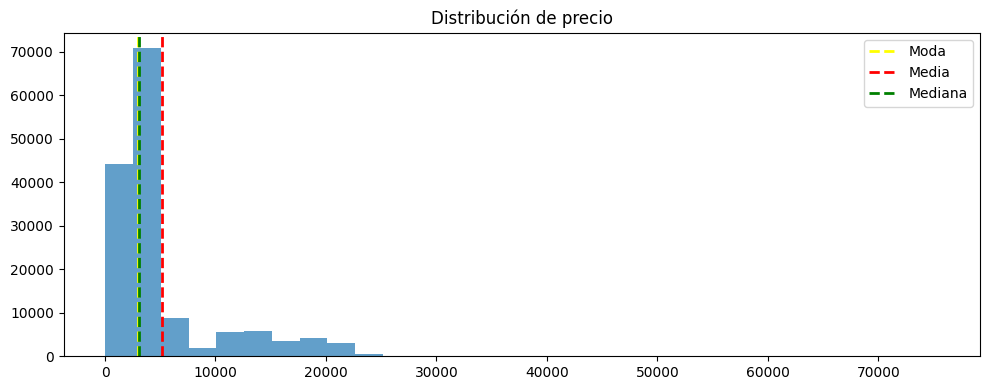

In [132]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.hist(data['precio'], bins=30, alpha=0.7) # dibujar histograma
ax.axvline(data['precio'].mode()[0], color='yellow', ls='--', lw=2, label='Moda')
ax.axvline(data['precio'].mean(), color='red', ls='--', lw=2, label='Media')
ax.axvline(data['precio'].median(), color='green', ls='--', lw=2, label='Mediana')
ax.set_title('Distribución de precio')
ax.legend()

plt.tight_layout()
plt.show()

Parece haber un valor outlier que perjudica la visualización.

In [133]:
data[data['precio']>30000].head(5)

,id_producto,id_comercio,fecha,id_bandera,id_sucursal,nombre_comercio,provincia,productos_descripcion,name,description,...,Manufacturer,Height,Number Of Items,volume_raw,volume_ml,precio,TieneDescripcion,brand_clean,brand_normalizada,volume_ml_redondeado
19802,7792798002399,2013,2025-01-03,1,1,Mercado Libre,AR-C,Pack X6 Cervezas Kilometro 24.7 En Botella 438...,Patagonia 24_7 Cerveza 24.7 730 Ml,"Cerveza rubia amarga, de un color dorado ayuda...",...,NaN,NaN,NaN,730 ml,730.0,31596.0,1,PATAGONIA 24_7,PATAGONIA,700.0
19803,7792798002399,2013,2025-01-04,1,1,Mercado Libre,AR-C,Pack X6 Cervezas Kilometro 24.7 En Botella 438...,Patagonia 24_7 Cerveza 24.7 730 Ml,"Cerveza rubia amarga, de un color dorado ayuda...",...,NaN,NaN,NaN,730 ml,730.0,31596.0,1,PATAGONIA 24_7,PATAGONIA,700.0
19804,7792798002399,2013,2025-01-05,1,1,Mercado Libre,AR-C,Pack X6 Cervezas Kilometro 24.7 En Botella 438...,Patagonia 24_7 Cerveza 24.7 730 Ml,"Cerveza rubia amarga, de un color dorado ayuda...",...,NaN,NaN,NaN,730 ml,730.0,31596.0,1,PATAGONIA 24_7,PATAGONIA,700.0
19805,7792798002399,2013,2025-01-06,1,1,Mercado Libre,AR-C,Pack X6 Cervezas Kilometro 24.7 En Botella 438...,Patagonia 24_7 Cerveza 24.7 730 Ml,"Cerveza rubia amarga, de un color dorado ayuda...",...,NaN,NaN,NaN,730 ml,730.0,31596.0,1,PATAGONIA 24_7,PATAGONIA,700.0
19806,7792798002399,2013,2025-01-07,1,1,Mercado Libre,AR-C,Pack X6 Cervezas Kilometro 24.7 En Botella 438...,Patagonia 24_7 Cerveza 24.7 730 Ml,"Cerveza rubia amarga, de un color dorado ayuda...",...,NaN,NaN,NaN,730 ml,730.0,31596.0,1,PATAGONIA 24_7,PATAGONIA,700.0


In [134]:
data[data['precio']>30000]['productos_descripcion'].value_counts()

productos_descripcion
Cerveza Corona Porron 330ml X 24 Unidades                       120
Pack X12 Cervezas Pale Lager 710 Cc Corona                      120
Cerveza Corona Sin Alcohol No Retornable 330mlx24 Unidades      120
Pack X24 Cervezas Belgium Rubia 330ml Cada Una Stella Artois    101
VASO CERVEZA MUNICH NADIR 530ml                                  86
Pack X6 Cervezas Kilometro 24.7 En Botella 4380ml Patagonia      27
Name: count, dtype: int64

Los outliers se tratan de precios que estan a nivel pack y no a nivel unitario. Y existen registros de vasos que se deben eliminar. 

In [135]:
# Elimino registros de vasos
data = data[data['productos_descripcion'] != 'VASO CERVEZA MUNICH NADIR 530ml']

In [136]:
# Mapeo de palabras a números
numeros_palabra = {
    'one': 1,
    'two': 2,
    'three': 3,
    'four': 4,
    'five': 5,
    'six': 6,
    'seven': 7,
    'eight': 8,
    'nine': 9,
    'ten': 10,
    'twelve': 12,
    'twenty': 20
}

def detectar_pack(desc):
    desc = str(desc).lower()

    # 1. "pack x6", "pack x 12", "packx24"
    match1 = re.search(r'pack\s*x?\s*(\d+)', desc)
    if match1:
        return int(match1.group(1))

    # 2. "x24 unidades", "x 24 unidades"
    match2 = re.search(r'x\s*(\d+)\s*unidades?', desc)
    if match2:
        return int(match2.group(1))

    # 3. "330mlx24 unidades", "710mlx6"
    match3 = re.search(r'ml\s*[x×]?\s*(\d+)', desc)
    if match3:
        return int(match3.group(1))

    # 4. "24 unidades"
    match4 = re.search(r'(\d+)\s*unidades?', desc)
    if match4:
        return int(match4.group(1))

    # 5. "x6", "x 6"
    match5 = re.search(r'\bx\s*(\d{1,2})\b', desc)
    if match5:
        return int(match5.group(1))

    # 6. "six pack", "twelve pack", etc.
    for palabra, valor in numeros_palabra.items():
        if re.search(rf'\b{palabra}\s*pack\b', desc):
            return valor

    return 1

In [137]:
data['pack'] = data['productos_descripcion'].apply(detectar_pack)
data['precio_unitario'] = data['precio'] / data['pack']

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_10267/4121869937.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x='precio_unitario', hue='volume_ml_redondeado', fill=True, palette='Set2')


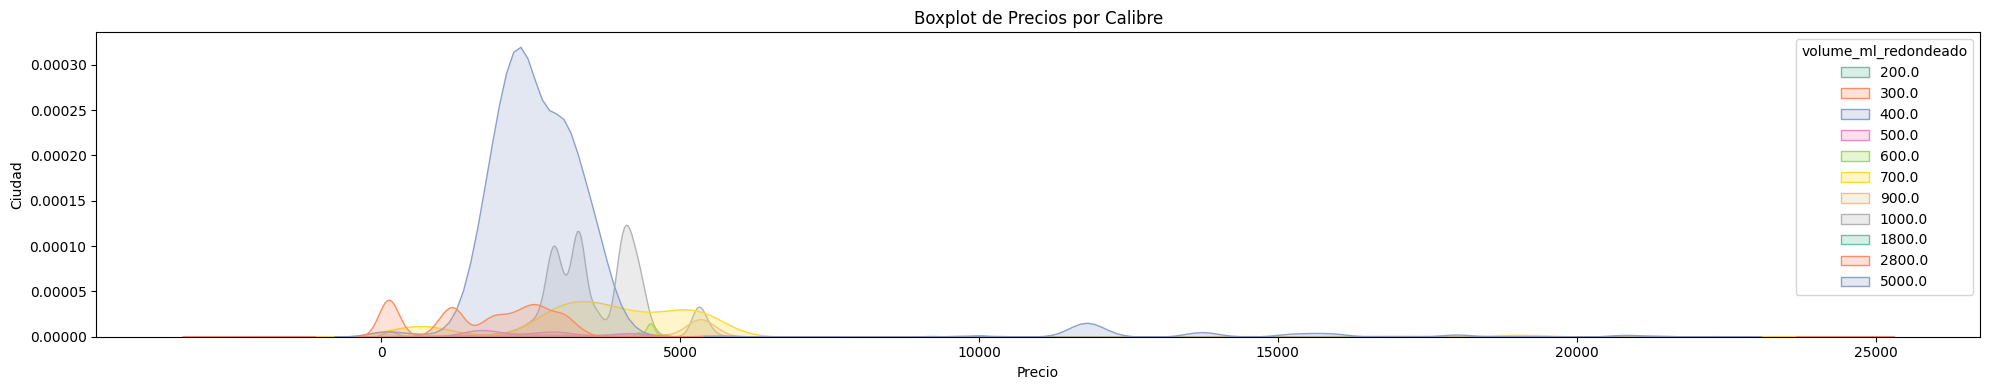

In [138]:
# Boxplot con escala logarítmica
plt.figure(figsize=(20, 4))
sns.kdeplot(data=data, x='precio_unitario', hue='volume_ml_redondeado', fill=True, palette='Set2')
plt.title("Boxplot de Precios por Calibre")
plt.xlabel("Precio")
plt.ylabel("Ciudad")
plt.tight_layout()
plt.show()

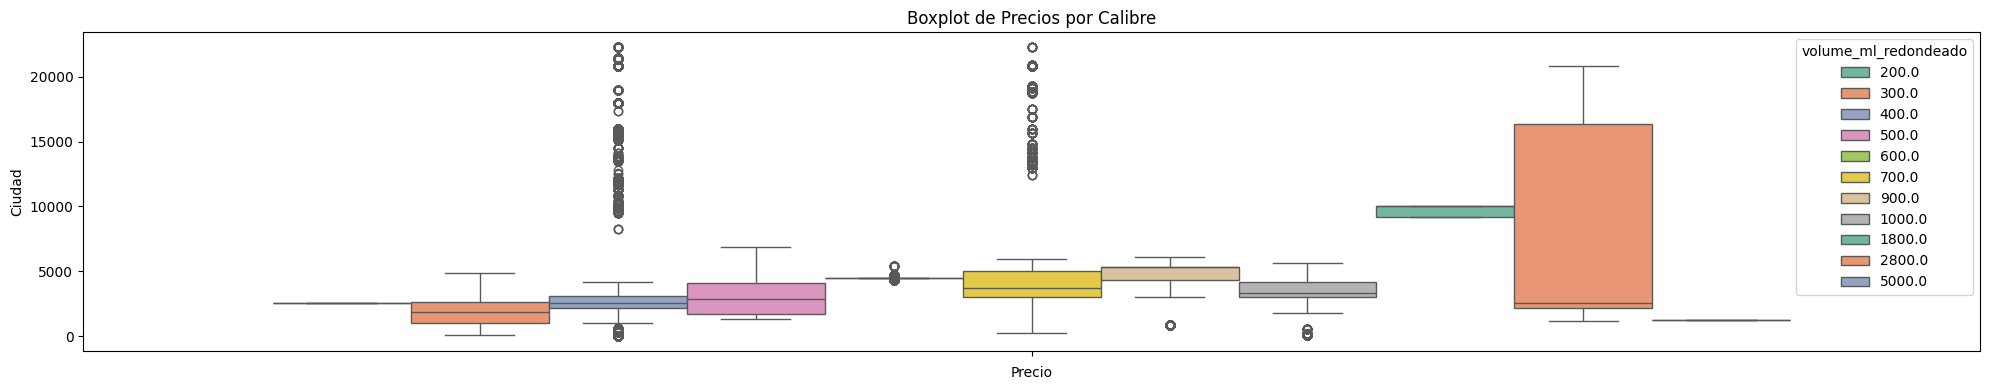

In [139]:
# Boxplot con escala logarítmica
plt.figure(figsize=(20, 4))
sns.boxplot(data=data, y='precio_unitario', hue='volume_ml_redondeado', palette='Set2')   
plt.title("Boxplot de Precios por Calibre")
plt.xlabel("Precio")
plt.ylabel("Ciudad")
plt.tight_layout()
plt.show()

In [140]:
def graficar_variacion_precio(df, columnas_agrupacion, freq='W'):
    df = df.copy()
    df['fecha'] = pd.to_datetime(df['fecha'])

    # Redondeamos la fecha a la frecuencia indicada
    df['fecha_agrupada'] = df['fecha'].dt.to_period(freq).dt.to_timestamp()

    # Agrupamos por fecha y las columnas indicadas
    agrupado = df.groupby(['fecha_agrupada'] + columnas_agrupacion)['precio_unitario'].mean().reset_index()

    # Graficamos
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=agrupado, x='fecha_agrupada', y='precio_unitario', hue=columnas_agrupacion[0])
    plt.title(f'Variación de precio promedio ({freq}) por {" + ".join(columnas_agrupacion)}')
    plt.ylabel('Precio promedio')
    plt.xlabel('Fecha')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

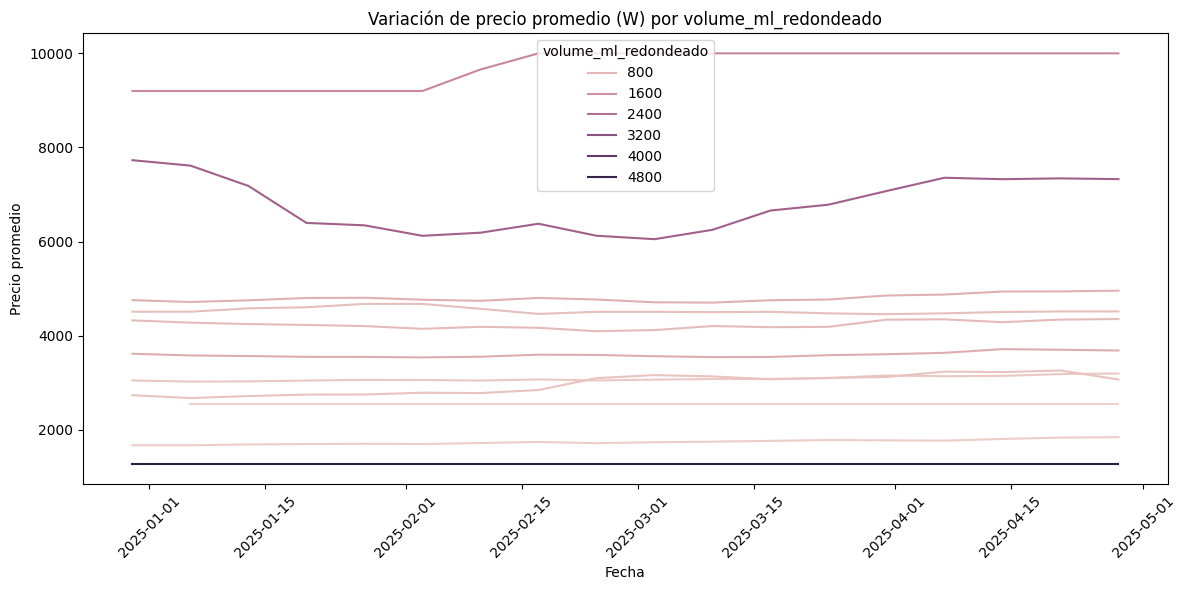

In [141]:
graficar_variacion_precio(data, ['volume_ml_redondeado'], freq='W')

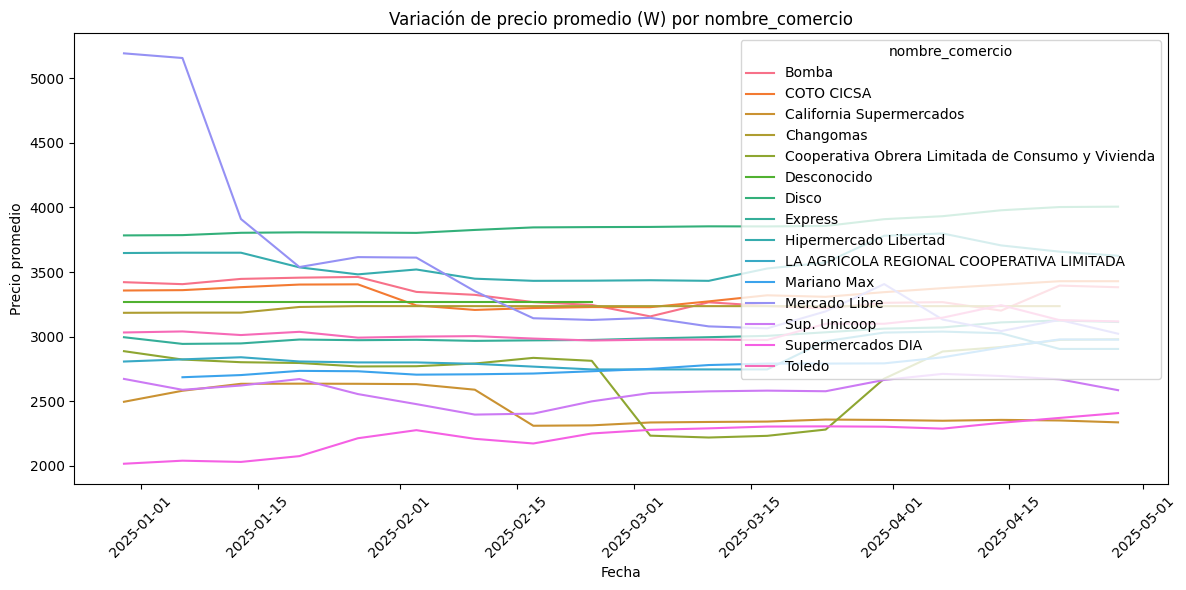

In [142]:
graficar_variacion_precio(data, ['nombre_comercio'], freq='W')

In [143]:
# Función auxiliar para graficar los tiempos por vuelta de cada piloto, para cada sector. Se puede graficar para una carrera o para todas juntas
def line_chart(volume, brand='all'):
    if brand == 'all':
        df = data[data['volume_ml_redondeado'] == volume]
    else:
        df = data[(data['volume_ml_redondeado'] == volume) & (data['brand_clean'] == brand)]

    # Asegurar que fecha sea datetime (por si acaso)
    df['fecha'] = pd.to_datetime(df['fecha'])

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=df,
        x='fecha',
        y='precio_unitario',
        hue='name',
        marker='o',
        alpha=0.8
    )

    plt.ylabel('Precio Unitario')
    plt.xlabel('Fecha')
    plt.title(f'Evolución del precio - Marca: {brand} - Volumen: {volume}ml', fontsize=13)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_10267/337906410.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fecha'] = pd.to_datetime(df['fecha'])


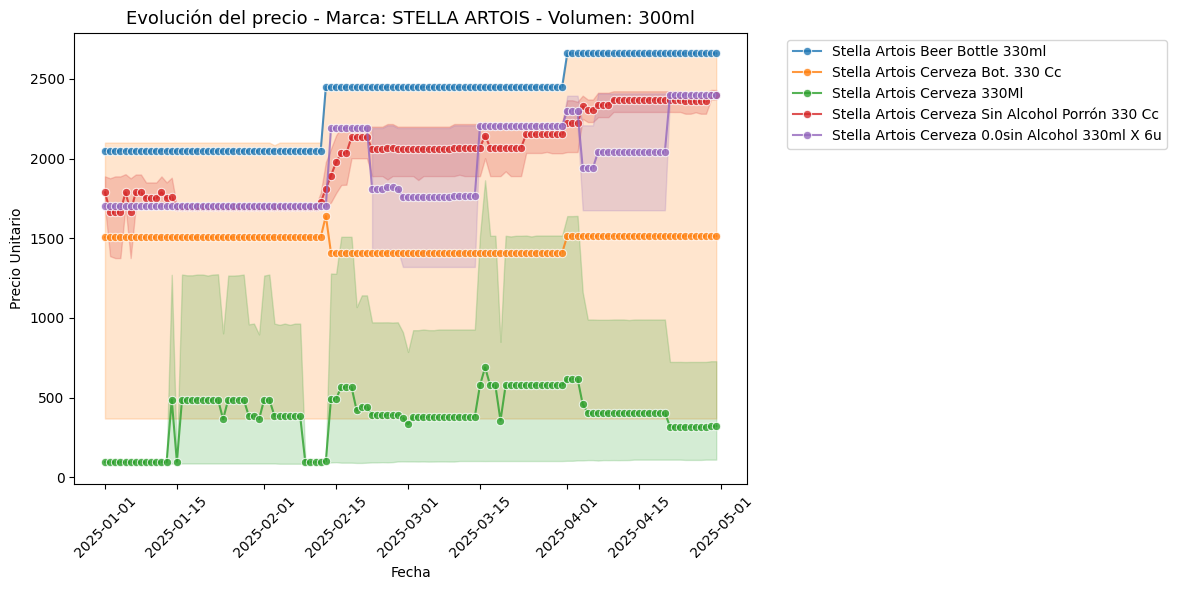

In [144]:
line_chart(300, 'STELLA ARTOIS')

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_10267/337906410.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fecha'] = pd.to_datetime(df['fecha'])


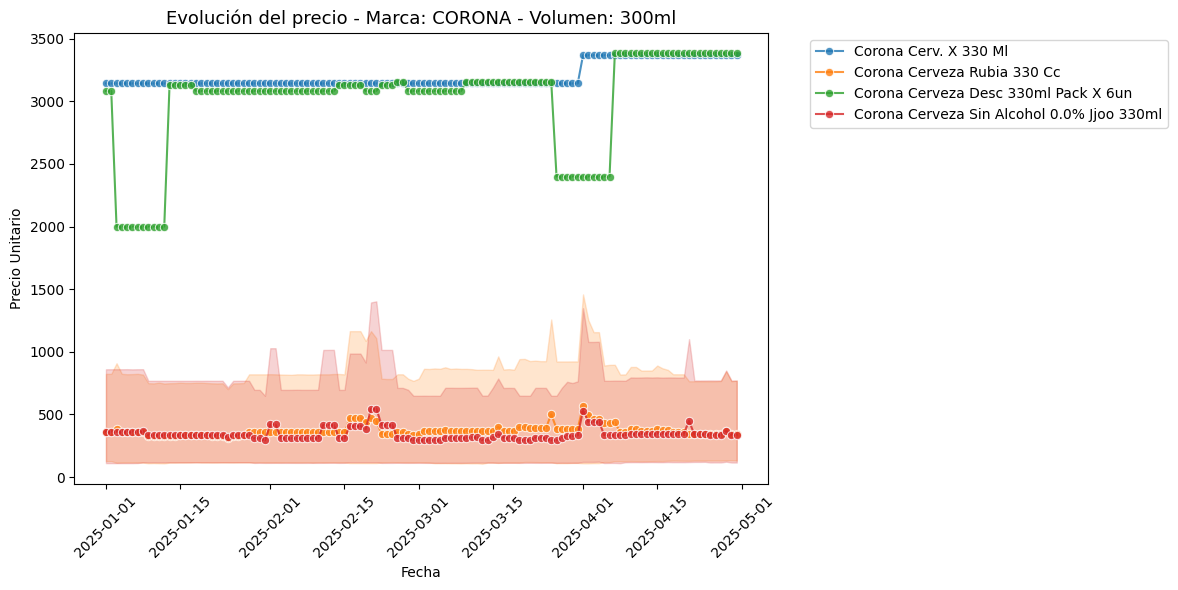

In [145]:
line_chart(300, 'CORONA')

### Datos Faltantes

In [146]:
# Serie con los valores faltantes
faltantes = data.isna().sum()

# Calculamos porcentaje de valores faltantes
total_filas = len(data)
faltantes_df = faltantes.to_frame(name='faltantes')
faltantes_df['porcentaje'] = ((faltantes_df['faltantes'] / total_filas) * 100).round(2)
faltantes_df = faltantes_df.sort_values(by='faltantes', ascending=False)

# Mostramos solo las que tienen valores faltantes
faltantes_df[faltantes_df['faltantes'] > 0]

,faltantes,porcentaje
Unit Size & Type,174480,99.93
Width,174480,99.93
Alcohol %,174480,99.93
Style,174480,99.93
Length,174480,99.93
Vintage,174480,99.93
Model Number,174480,99.93
Product Group,174480,99.93
Binding,174480,99.93
Part Number,174480,99.93


Las columnas creadas a partir de los specs suelen tener muchos nulos. Los specs se usan para alguuna aclaración inusual y no son obligatorios para todos los productos. Es por eso que la gran mayorisa de productos no tienen todas las categorias y se generan muchos nulos. 

Todas las variables con más del 90% de nulos se eliminarán.

In [147]:
# Identificamos columnas con más del 90% de nulos
columnas_a_eliminar = faltantes_df[faltantes_df['porcentaje'] > 90].index.tolist()

# Eliminamos esas columnas del DataFrame original
data = data.drop(columns=columnas_a_eliminar)

Se eliminan los registros con precio nulo.

In [148]:
data = data.dropna(subset=['precio'])

Se eliminan los registros con volumen nulo

In [153]:
data = data.dropna(subset=['volume_ml'])

Se eliminan los registros con marca nula

In [155]:
data = data.dropna(subset=['brand'])

Se reemplazan los size faltantes con volume_raw

In [157]:
data["Size"] = data["Size"].fillna(data["volume_raw"])

La columna countries se imputan con el valor Argentina.

In [159]:
data["Countries"] = data["Countries"].fillna("Argentina")

La categoria se imputa con la moda

In [160]:
# Calcular la moda
moda = data["category"].mode().iloc[0]

# Reemplazar nulos con la moda
data["category"] = data["category"].fillna(moda)

In [161]:
# Serie con los valores faltantes
faltantes = data.isna().sum()

# Calculamos porcentaje de valores faltantes
total_filas = len(data)
faltantes_df = faltantes.to_frame(name='faltantes')
faltantes_df['porcentaje'] = ((faltantes_df['faltantes'] / total_filas) * 100).round(2)
faltantes_df = faltantes_df.sort_values(by='faltantes', ascending=False)

# Mostramos solo las que tienen valores faltantes
faltantes_df[faltantes_df['faltantes'] > 0]

,faltantes,porcentaje


#### Almaceno Base Final

In [162]:
data.to_csv("../data/precios_cervezas_2025_preprocesado.csv", index=False)